In [2]:
import cv2
import matplotlib.pyplot as plt
from cv2.typing import *
import numpy as np


def load_image():
    image = cv2.imread("images/image.png")
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


def display_image(image: MatLike, title: str):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')  # Turn off the axis
    plt.show()


def quantize_image(image: MatLike, n_colors):
    Z = image.reshape((-1, 3))
    # convert to np.float32
    Z = np.float32(Z)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, label, center = cv2.kmeans(
        Z, n_colors, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    final_image = res.reshape((image.shape))

    return final_image

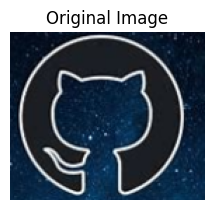

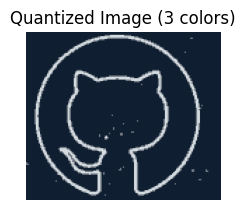

In [7]:
colors = 3
quantized_image = quantize_image(load_image(), colors)

plt.figure(1)
plt.subplot(223)
display_image(load_image(), 'Original Image')

plt.figure(2)
plt.subplot(223)
display_image(quantized_image, f'Quantized Image ({colors} colors)')